In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# ---------- collate ----------


def collate_keep_meta(batch):
    x = torch.stack([b["x_hist"] for b in batch])      # [B, L, F]
    y = torch.stack([b["y_future"] for b in batch])    # [B, H]
    lat = torch.tensor([b["lat"] for b in batch], dtype=torch.float32)
    lon = torch.tensor([b["lon"] for b in batch], dtype=torch.float32)
    meta = {
        "tile_id":   [b["tile_id"] for b in batch],
        "start_time": [str(b["start_time"]) for b in batch],
        "lat": lat, "lon": lon,
    }
    return {"x_hist": x, "y_future": y, "meta": meta}


# ---------- 1) Identify feature columns ----------
NON_FEATURE_COLS = {
    "lon", "lat", "time", "source_file", "PM25_MERRA2", "PM25_ug_m3", "class"
}


def get_feature_cols(df: pd.DataFrame):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feat_cols = [c for c in num_cols if c not in NON_FEATURE_COLS and c.lower() not in {
        "timestamp"}]
    return feat_cols

# ---------- 2) Parse/tidy WITHOUT resampling/filling ----------


def prepare_dataframe_noresample(df: pd.DataFrame, dayfirst=True) -> pd.DataFrame:
    """
    - Parse df['time'] -> 'timestamp'
    - Build 'tile_id'
    - Keep only numeric features + target + coords + timestamp
    - No resampling, no filling. Leave raw granularity intact.
    """
    df = df.copy()
    df["timestamp"] = pd.to_datetime(
        df["time"], dayfirst=dayfirst, errors="coerce")
    df["tile_id"] = (df["lat"].round(4).astype(str) +
                     "_" + df["lon"].round(4).astype(str))

    feat_cols = get_feature_cols(df)
    keep = ["timestamp", "tile_id", "lat", "lon", "PM25_ug_m3"] + feat_cols
    df = df[keep].dropna(subset=["timestamp"]).sort_values(
        ["tile_id", "timestamp"])

    # numeric types, no fill
    df[feat_cols + ["PM25_ug_m3"]] = df[feat_cols +
                                        ["PM25_ug_m3"]].astype(float)
    return df

# ---------- 3) Stats from TRAIN only ----------


def compute_feature_stats(df: pd.DataFrame):
    feat_cols = get_feature_cols(df)
    mean = df[feat_cols].mean(skipna=True).astype("float32").values
    std = df[feat_cols].std(ddof=0, skipna=True).replace(
        0, 1.0).astype("float32").values
    return feat_cols, mean, std

# ---------- 4) Detect dominant cadence (in minutes) ----------


def dominant_cadence_minutes(df: pd.DataFrame) -> int:
    def _dmins(g):
        return g["timestamp"].sort_values().diff().dt.total_seconds().div(60).round().dropna().astype(int)
    vc = (df.groupby("tile_id", group_keys=False)
            .apply(_dmins)
            .rename("delta_min")
            .to_frame()["delta_min"]
            .value_counts())
    return int(vc.idxmax()) if len(vc) else 60  # default hourly

# ---------- 5) Build strict window indices on native cadence ----------


def build_indices_strict_native(df: pd.DataFrame, feat_cols, L=168, H=72, stride=1, cadence_min=60):
    """
    Only emit windows fully contained in contiguous runs where successive timestamps differ by `cadence_min`.
    No NaNs allowed in the L-step history (features) and H-step future (target).
    """
    idx = []
    for tile, g in df.groupby("tile_id"):
        g = g.sort_values("timestamp").reset_index(drop=True)
        if len(g) < L + H:
            continue

        # mark contiguous runs at cadence_min
        t = g["timestamp"].values.astype("datetime64[m]")
        d = np.diff(t).astype("timedelta64[m]").astype(int)
        same = np.r_[True, d == cadence_min]   # True = continues the run
        # increment id when a break occurs
        run_id = np.cumsum(~same)

        # precompute masks (row-level)
        feat_ok = g[feat_cols].notna().all(axis=1).to_numpy()
        y_ok = g["PM25_ug_m3"].notna().to_numpy()

        for rid, gr in g.groupby(run_id):
            n = len(gr)
            if n < L + H:
                continue

            # indices for this run within g
            lo = gr.index.min()
            hi = gr.index.max()
            # slice masks for this run
            f = feat_ok[lo:hi+1]
            y = y_ok[lo:hi+1]

            # rolling “all good” checks using cumulative sum (fast, no pandas)
            # For history end at i-1 (0-based inside run), need sum(f[i-L:i]) == L
            # For future start at i, need sum(y[i:i+H]) == H
            cs_f = np.r_[0, np.cumsum(f.astype(int))]
            cs_y = np.r_[0, np.cumsum(y.astype(int))]

            # iterate valid i within the run
            for i in range(L, n - H + 1, stride):
                hist_ok = (cs_f[i] - cs_f[i - L]) == L
                fut_ok = (cs_y[i + H] - cs_y[i]) == H
                if hist_ok and fut_ok:
                    # store global index “t” (the first future step index within the full group g)
                    t_global = lo + i
                    idx.append((tile, t_global))
    return idx

# ---------- 6) Dataset on native cadence ----------


class TSWindowDatasetNative(Dataset):
    def __init__(self, df: pd.DataFrame, L=168, H=72, stride=1, stats=None, cadence_min=None):
        """
        df: output of prepare_dataframe_noresample()
        L, H, stride: window spec
        stats: (feat_cols, mean, std) from TRAIN ONLY
        cadence_min: dominant cadence in minutes (detected from TRAIN)
        """
        self.df = df
        self.L, self.H = L, H
        self.feat_cols, self.mean, self.std = stats if stats is not None else compute_feature_stats(
            df)
        self.groups = {tile: g.reset_index(drop=True)
                       for tile, g in df.groupby("tile_id")}
        self.cadence_min = int(
            cadence_min) if cadence_min is not None else dominant_cadence_minutes(df)
        self.idx = build_indices_strict_native(
            df, self.feat_cols, L, H, stride, self.cadence_min)

    def __len__(self): return len(self.idx)

    def __getitem__(self, i):
        tile, t = self.idx[i]
        g = self.groups[tile]

        hist = g.loc[t-self.L:t-1, self.feat_cols].values.astype(np.float32)
        if np.isnan(hist).any():
            raise ValueError("NaNs found in x_hist despite strict index mask.")
        hist = ((hist - self.mean) / self.std).astype(np.float32)

        fut = g.loc[t:t+self.H-1, "PM25_ug_m3"].values.astype(np.float32)
        if np.isnan(fut).any():
            raise ValueError(
                "NaNs found in y_future despite strict index mask.")

        start_ts = g.loc[t, "timestamp"]
        lat = float(g["lat"].iloc[0])
        lon = float(g["lon"].iloc[0])

        return {
            "x_hist": torch.from_numpy(hist),
            "y_future": torch.from_numpy(fut),
            "tile_id": tile,
            "start_time": pd.Timestamp(start_ts),
            "lat": lat, "lon": lon,
        }


# ---------- 7) Quick usage / smoke on the 100k CSV ----------
if __name__ == "__main__":
    df_raw = pd.read_csv("first_500K_rows_filtered.csv")
    df0 = prepare_dataframe_noresample(df_raw, dayfirst=True)

    # time-based split FIRST (no resample)
    cutoff = df0["timestamp"].quantile(0.80)
    train_raw = df0[df0["timestamp"] <= cutoff].copy()
    val_raw = df0[df0["timestamp"] > cutoff].copy()

    # detect cadence from TRAIN
    cad_min = dominant_cadence_minutes(train_raw)
    print(f"\nDetected dominant cadence: {cad_min} minutes")

    # stats from TRAIN only
    feat_cols, mean, std = compute_feature_stats(train_raw)
    F = len(feat_cols)

    # SMALLER windows for this 100k slice (each tile has ~25-hour runs)
    L, H, stride = 32, 12, 2

    train_ds = TSWindowDatasetNative(train_raw, L=32, H=H, stride=8,
                                     stats=(feat_cols, mean, std), cadence_min=cad_min)
    val_ds = TSWindowDatasetNative(val_raw,   L=32, H=H, stride=8,
                                   stats=(feat_cols, mean, std), cadence_min=cad_min)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=False,
                              drop_last=True,  collate_fn=collate_keep_meta)
    val_loader = DataLoader(val_ds,   batch_size=64, shuffle=False,
                            drop_last=False, collate_fn=collate_keep_meta)

    print("#train windows:", len(train_ds), "| #val windows:", len(val_ds))

    # sanity batch
    if len(train_ds) > 0:
        b = next(iter(train_loader))
        Xb, Yb = b["x_hist"], b["y_future"]
        print("batch x shape:", tuple(Xb.shape), "| y shape:", tuple(Yb.shape))

/var/folders/_g/_2_30kss2g3bdxs940406y_r0000gn/T/ipykernel_7949/94371877.py:60: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_dmins)



Detected dominant cadence: 60 minutes
#train windows: 3600 | #val windows: 800
batch x shape: (64, 32, 36) | y shape: (64, 12)


In [ ]:
# 1) Parse + make tile ids (no resample)
df0 = prepare_dataframe_noresample(df_raw, dayfirst=True)

# 2) Time split first (no leakage)
cutoff = df0["timestamp"].quantile(0.80)
train_raw = df0[df0["timestamp"] <= cutoff].copy()
val_raw = df0[df0["timestamp"] > cutoff].copy()

# 3) Detect cadence from TRAIN
cad_min = dominant_cadence_minutes(train_raw)

# 4) Stats from TRAIN only
feat_cols, mean, std = compute_feature_stats(train_raw)

# 5) Datasets (strict windows — no NaNs, native cadence)
# For the 100k file, each tile has ~25-hour runs → use smaller L/H here.
L, H, stride = 32, 12, 2
train_ds = TSWindowDatasetNative(train_raw, L=32, H=H, stride=8,
                                 stats=(feat_cols, mean, std), cadence_min=cad_min)
val_ds = TSWindowDatasetNative(val_raw,   L=32, H=H, stride=8,
                               stats=(feat_cols, mean, std), cadence_min=cad_min)

# ---- loaders ----
train_loader = DataLoader(train_ds, batch_size=64, shuffle=False,
                          drop_last=True,  collate_fn=collate_keep_meta)
val_loader = DataLoader(val_ds,   batch_size=64, shuffle=False,
                        drop_last=False, collate_fn=collate_keep_meta)

print("#train windows:", len(train_ds), "| #val windows:", len(val_ds))

/var/folders/_g/_2_30kss2g3bdxs940406y_r0000gn/T/ipykernel_7949/94371877.py:60: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_dmins)


#train windows: 3600 | #val windows: 800


In [ ]:
import math
import torch.nn as nn
import torch


def sinusoidal_positional_encoding(n_pos: int, d_model: int, device=None):
    pe = torch.zeros(n_pos, d_model, device=device)
    pos = torch.arange(0, n_pos, device=device).unsqueeze(1).float()
    div = torch.exp(torch.arange(
        0, d_model, 2, device=device).float() * (-math.log(10000.0)/d_model))
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe  # [N, d]


class PatchPosEncoder(nn.Module):
    def __init__(self, in_features, patch_len=16, stride=8, d_model=128):
        super().__init__()
        self.P, self.S, self.F, self.d = patch_len, stride, in_features, d_model
        self.proj = nn.Linear(self.P * self.F, self.d)

    def forward(self, x):           # x: [B, L, F]
        B, L, F = x.shape
        starts = range(0, L - self.P + 1, self.S)
        patches = [
            x[:, s:s+self.P, :].reshape(B, self.P*self.F) for s in starts]
        T = torch.stack(patches, dim=1)              # [B, N, P*F]
        T = self.proj(T)                             # [B, N, d]
        pe = sinusoidal_positional_encoding(T.size(1), self.d, device=x.device)
        return T + pe                                # [B, N, d]


class SimplePatcherHead(nn.Module):
    def __init__(self, in_features, L, H, patch_len=16, stride=8, d_model=128):
        super().__init__()
        self.enc = PatchPosEncoder(in_features, patch_len, stride, d_model)
        self.head = nn.Linear(d_model, H)

    def forward(self, x_hist):      # [B, L, F]
        tokens = self.enc(x_hist)   # [B, N, d]
        pooled = tokens[:, -1]      # last-token pool (or tokens.mean(dim=1))

        return self.head(pooled)    # [B, H]

# QLSTM


In [ ]:
# === QLSTM cell + wrapper that uses your PatchPosEncoder ===
import pennylane as qml
import torch
import torch.nn as nn


class zzfeatuermapQLSTM(nn.Module):
    """
    Quantum LSTM cell:
      concat([h_t, x_t]) -> Linear -> n_qubits
      -> IQPEmbedding + BasicEntanglerLayers -> Z expvals
      -> Linear -> hidden_size
      -> standard LSTM updates
    """

    def __init__(self, input_size, hidden_size, n_qubits=4, n_qlayers=1, backend="default.qubit"):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.concat_size = input_size + hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers

        # Separate devices per gate
        self.dev_forget = qml.device(backend, wires=n_qubits)
        self.dev_input = qml.device(backend, wires=n_qubits)
        self.dev_update = qml.device(backend, wires=n_qubits)
        self.dev_output = qml.device(backend, wires=n_qubits)

        # Gate circuits (same topology for each)  <-- NOTE the arg name: inputs
        def _circuit_forget(inputs, weights):
            for n in range(n_qlayers):
                qml.templates.IQPEmbedding(
                    inputs, wires=range(n_qubits), n_repeats=5)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        def _circuit_input(inputs, weights):
            for n in range(n_qlayers):
                qml.templates.IQPEmbedding(
                    inputs, wires=range(n_qubits), n_repeats=5)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        def _circuit_update(inputs, weights):
            for n in range(n_qlayers):
                qml.templates.IQPEmbedding(
                    inputs, wires=range(n_qubits), n_repeats=5)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        def _circuit_output(inputs, weights):
            for n in range(n_qlayers):
                qml.templates.IQPEmbedding(
                    inputs, wires=range(n_qubits), n_repeats=5)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        # Older TorchLayer: just pass the QNode and weight_shapes
        self.qlayer_forget = qml.qnn.TorchLayer(
            qml.QNode(_circuit_forget, self.dev_forget, interface="torch"),
            weight_shapes
        )
        self.qlayer_input = qml.qnn.TorchLayer(
            qml.QNode(_circuit_input,  self.dev_input,  interface="torch"),
            weight_shapes
        )
        self.qlayer_update = qml.qnn.TorchLayer(
            qml.QNode(_circuit_update, self.dev_update, interface="torch"),
            weight_shapes
        )
        self.qlayer_output = qml.qnn.TorchLayer(
            qml.QNode(_circuit_output, self.dev_output, interface="torch"),
            weight_shapes
        )

        # Classical pre/post
        # [h_t, x_t] -> n_qubits
        self.clayer_in = nn.Linear(self.concat_size, n_qubits)
        # Z-expvals -> hidden_size
        self.clayer_out = nn.Linear(n_qubits, hidden_size)

    def forward(self, x, init_states=None):
        """
        x: [B, N, input_size]  (your Patch+PosEnc tokens)
        returns: hidden_seq [B, N, hidden], (h_T, c_T)
        """
        B, N, _ = x.size()
        if init_states is None:
            h_t = torch.zeros(B, self.hidden_size,
                              device=x.device, dtype=x.dtype)
            c_t = torch.zeros(B, self.hidden_size,
                              device=x.device, dtype=x.dtype)
        else:
            h_t, c_t = init_states

        h_list = []
        for t in range(N):
            x_t = x[:, t, :]                         # [B, input_size]
            v_t = torch.cat([h_t, x_t], dim=1)       # [B, hidden+input]
            y_t = self.clayer_in(v_t)                # [B, n_qubits]

            f_t = torch.sigmoid(self.clayer_out(
                self.qlayer_forget(y_t)))  # [B, hidden]
            i_t = torch.sigmoid(self.clayer_out(
                self.qlayer_input(y_t)))  # [B, hidden]
            g_t = torch.tanh(self.clayer_out(
                self.qlayer_update(y_t)))  # [B, hidden]
            o_t = torch.sigmoid(self.clayer_out(
                self.qlayer_output(y_t)))  # [B, hidden]

            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            h_list.append(h_t.unsqueeze(1))

        hidden_seq = torch.cat(h_list, dim=1)        # [B, N, hidden]
        return hidden_seq, (h_t, c_t)


class PatchToQLSTM72(nn.Module):
    """
    PatchPosEncoder (yours) -> QLSTM over tokens -> Linear -> H (e.g., 72).
    """

    def __init__(self, in_features, L, H, patch_len=16, stride=8,
                 d_model=128, hidden_size=128, n_qubits=4, n_qlayers=1, backend="default.qubit"):
        super().__init__()
        self.use_quantum = (n_qubits > 0 and n_qlayers > 0)

        # uses your existing class
        self.enc = PatchPosEncoder(in_features, patch_len, stride, d_model)
        if self.use_quantum:
            self.qlstm = zzfeatuermapQLSTM(input_size=d_model, hidden_size=hidden_size,
                                           n_qubits=n_qubits, n_qlayers=n_qlayers, backend=backend)
        else:
            self.qlstm = nn.LSTM(
                input_size=d_model,
                hidden_size=hidden_size,
                batch_first=True
            )

        self.head = nn.Linear(hidden_size, H)

    def forward(self, x_hist):               # x_hist: [B, L, F]
        tokens = self.enc(x_hist)            # [B, N, d_model]
        h_seq, (hT, cT) = self.qlstm(tokens)  # [B, N, hidden]
        return self.head(h_seq[:, -1, :])    # [B, H]

In [5]:
# --- Build the QLSTM model (must run before the training loop) ---
F = len(feat_cols)  # number of features from your dataframe pipeline

# If you have default backends installed you can swap "default.qubit" -> "lightning.qubit" (CPU) or "lightning.gpu"
backend = "default.qubit"

P = min(8, L)          # e.g., 8 when L=12
S = max(1, P // 2)     # e.g., 4

qlstm_model = PatchToQLSTM72(
    in_features=F, L=L, H=H,
    patch_len=P, stride=S,      # <-- changed
    d_model=128, hidden_size=128,
    n_qubits=4, n_qlayers=1, backend="default.qubit"
)


# (optional) quick smoke test so we fail early if shapes don’t match
with torch.no_grad():
    _ = qlstm_model(next(iter(train_loader))["x_hist"][:2])
print("QLSTM model built and forward pass OK.")

QLSTM model built and forward pass OK.


# QGRU


In [ ]:
# === QGRU cell + wrapper that uses your PatchPosEncoder (drop-in alongside QLSTM) ===
import pennylane as qml
import torch
import torch.nn as nn


class zzfeatuermapQGRU(nn.Module):
    """
    Quantum GRU cell:
      Gates (reset/update/new) are VQCs.
      - For r,z gates: concat([h_t, x_t]) -> Linear -> n_qubits -> QNode -> Linear -> hidden_size
      - For candidate n_t: concat([r_t * h_t, x_t]) -> Linear -> n_qubits -> QNode -> Linear -> hidden_size
      - Standard GRU update: h_t = (1 - z_t) * n_t + z_t * h_{t-1}
    """

    def __init__(self, input_size, hidden_size, n_qubits=4, n_qlayers=1, backend="default.qubit"):
        super().__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend

        # unique wire names per gate (separate devices)
        self.wires_reset = [f"wire_reset_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_new = [f"wire_new_{i}" for i in range(self.n_qubits)]

        self.dev_reset = qml.device(self.backend, wires=self.wires_reset)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_new = qml.device(self.backend, wires=self.wires_new)

        # circuits: IQPEmbedding + BasicEntanglerLayers -> Z expvals
        def _circuit_reset(inputs, weights):
            for n in range(n_qlayers):
                qml.templates.IQPEmbedding(
                    inputs, wires=self.wires_reset, n_repeats=2)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=self.wires_reset)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=self.wires_reset)
            return [qml.expval(qml.PauliZ(w)) for w in self.wires_reset]

        def _circuit_update(inputs, weights):
            for n in range(n_qlayers):
                qml.templates.IQPEmbedding(
                    inputs, wires=self.wires_update, n_repeats=2)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=self.wires_update)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(w)) for w in self.wires_update]

        def _circuit_new(inputs, weights):
            for n in range(n_qlayers):
                qml.templates.IQPEmbedding(
                    inputs, wires=self.wires_new, n_repeats=2)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=self.wires_new)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=self.wires_new)
            return [qml.expval(qml.PauliZ(w)) for w in self.wires_new]

        # def _circuit_final(inputs, weights):
        #     qml.templates.IQPEmbedding(inputs, wires=self.wires_new)
        #     qml.templates.BasicEntanglerLayers(weights, wires=self.wires_new)
        #     return [qml.expval(qml.PauliZ(w)) for w in self.wires_new]

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        self.qlayer_reset = qml.qnn.TorchLayer(
            qml.QNode(_circuit_reset,  self.dev_reset,  interface="torch"), weight_shapes)
        self.qlayer_update = qml.qnn.TorchLayer(
            qml.QNode(_circuit_update, self.dev_update, interface="torch"), weight_shapes)
        self.qlayer_new = qml.qnn.TorchLayer(
            qml.QNode(_circuit_new,    self.dev_new,    interface="torch"), weight_shapes)
        # self.qlayer_final   = qml.qnn.TorchLayer(qml.QNode(_circuit_new,    self.dev_new,    interface="torch"), weight_shapes)

        # classical pre/post
        self.clayer_in_gates = nn.Linear(self.concat_size, n_qubits)  # for r,z
        # for candidate n with (r ⊙ h)
        self.clayer_in_cand = nn.Linear(self.concat_size, n_qubits)
        self.clayer_out = nn.Linear(self.n_qubits, self.hidden_size)

        # self.clayer_in_final = nn.Linear(self.hidden_size, n_qubits)  # for final output
        # self.clayer_out_final = nn.Linear(self.n_qubits, self.hidden_size)

    def forward(self, x, init_state=None):
        """
        x: [B, N, input_size]  tokens from Patch+PosEnc
        returns: hidden_seq [B, N, hidden], h_T
        """
        B, N, _ = x.size()
        hidden_seq = []

        if init_state is None:
            h_t = torch.zeros(B, self.hidden_size,
                              device=x.device, dtype=x.dtype)
        else:
            h_t = init_state

        for t in range(N):
            x_t = x[:, t, :]                              # [B, input_size]
            v_t = torch.cat((h_t, x_t), dim=1)            # [B, hidden+input]
            y_t = self.clayer_in_gates(v_t)               # [B, n_qubits]

            r_t = torch.sigmoid(self.clayer_out(
                self.qlayer_reset(y_t)))   # [B, hidden]
            z_t = torch.sigmoid(self.clayer_out(
                self.qlayer_update(y_t)))  # [B, hidden]

            v_cand = torch.cat((r_t * h_t, x_t), dim=1)   # [B, hidden+input]
            y_cand = self.clayer_in_cand(v_cand)          # [B, n_qubits]
            n_t = torch.tanh(self.clayer_out(
                self.qlayer_new(y_cand)))     # [B, hidden]

            h_t = (1.0 - z_t) * n_t + z_t * h_t
            # h_t = self.clayer_out_final(self.qlayer_final(self.clayer_in_final(h_t)))
            hidden_seq.append(h_t.unsqueeze(1))

        hidden_seq = torch.cat(hidden_seq, dim=1)         # [B, N, hidden]
        return hidden_seq, h_t


class PatchToQGRU72(nn.Module):
    """
    PatchPosEncoder (yours) -> QGRU over tokens -> Linear -> H (e.g., 72).
    Same interface as PatchToQLSTM72 so you can swap easily.
    """

    def __init__(self, in_features, L, H, patch_len=16, stride=8,
                 d_model=128, hidden_size=128, n_qubits=4, n_qlayers=1, backend="default.qubit"):
        super().__init__()

        self.use_quantum = (n_qubits > 0 and n_qlayers > 0)

        self.enc = PatchPosEncoder(in_features, patch_len, stride, d_model)

        if self.use_quantum:
            self.qgru = zzfeatuermapQGRU(input_size=d_model, hidden_size=hidden_size,
                                         n_qubits=n_qubits, n_qlayers=n_qlayers, backend=backend)
        else:
            self.qgru = nn.GRU(
                input_size=d_model,
                hidden_size=hidden_size,
                batch_first=True
            )

        self.head = nn.Linear(hidden_size, H)

    def forward(self, x_hist):                # x_hist: [B, L, F]
        tokens = self.enc(x_hist)             # [B, N, d_model]
        h_seq, hT = self.qgru(tokens)         # [B, N, hidden], [B, hidden]
        return self.head(h_seq[:, -1, :])     # [B, H]

In [7]:
# reuse your existing values: F=len(feat_cols), L, H, backend, train_loader
F = len(feat_cols)  # number of features from your dataframe pipeline

# If you have lightning backends installed you can swap "default.qubit" -> "lightning.qubit" (CPU) or "lightning.gpu"
backend = "default.qubit"

P = min(8, L)          # e.g., 8 when L=12
S = max(1, P // 2)     # e.g., 4

qgru_model = PatchToQGRU72(
    in_features=F, L=L, H=H,
    patch_len=P, stride=S,
    d_model=128, hidden_size=128,
    n_qubits=4, n_qlayers=2,
    backend=backend
)

with torch.no_grad():
    _ = qgru_model(next(iter(train_loader))["x_hist"][:2])
print("QGRU model built and forward pass OK.")

# If you want to train QGRU **without touching your training loop** that references `qlstm_model`,
# simply alias it:
qlstm_model = qgru_model

QGRU model built and forward pass OK.


# Training loop


In [ ]:
# ===== Experiment training runner (QLSTM + QGRU) =====
import os
import json
import time
import csv
import datetime
import numpy as np
import torch
import torch.nn as nn


def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)


def _ensure_dir(d):
    os.makedirs(d, exist_ok=True)
    return d


def _latest_ckpt(ckpt_dir):
    if not os.path.isdir(ckpt_dir):
        return None
    files = [f for f in os.listdir(ckpt_dir) if f.startswith(
        "epoch_") and f.endswith(".pt")]
    if not files:
        return None
    files.sort()
    return os.path.join(ckpt_dir, files[-1])


def _compute_y_stats(train_loader, device):
    with torch.no_grad():
        ys = []
        for b in train_loader:
            ys.append(b["y_future"])
        y_all = torch.cat(ys, dim=0).float()
    y_mean = y_all.mean().to(device)
    y_std = y_all.std(unbiased=False).clamp_min(1e-6).to(device)
    return y_mean, y_std


def train_and_log(model, model_name, train_loader, val_loader,
                  epochs=30, lr=1e-3, weight_decay=0.0, grad_clip=0.5,
                  out_root="runs", device=torch.device("cpu"), save_every=1,
                  run_dir=None, resume_from=None, use_scheduler=False,
                  log_iter_every=200):
    """
    Train a model and log everything to a run folder. Supports resume.

    NEW: log_iter_every -> print progress every N iterations (batches)
         Set to 1 to print every batch; for huge datasets prefer 200–1000.
    """
    # --- Decide run_dir ---
    if resume_from and os.path.isfile(resume_from):
        run_dir = os.path.dirname(os.path.dirname(resume_from))
    elif resume_from and os.path.isdir(resume_from):
        run_dir = resume_from
    elif run_dir and not os.path.isdir(run_dir):
        _ensure_dir(run_dir)
    elif run_dir is None:
        ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        run_dir = _ensure_dir(os.path.join(out_root, f"{ts}_{model_name}"))

    ckpt_dir = _ensure_dir(os.path.join(run_dir, "checkpoints"))
    preds_dir = _ensure_dir(os.path.join(run_dir, "preds"))
    log_csv = os.path.join(run_dir, "losses.csv")

    # --- Compose resume_path ---
    resume_path = None
    if isinstance(resume_from, str):
        if resume_from == "latest":
            resume_path = _latest_ckpt(ckpt_dir)
        elif os.path.isdir(resume_from):
            resume_path = _latest_ckpt(
                os.path.join(resume_from, "checkpoints"))
        elif os.path.isfile(resume_from):
            resume_path = resume_from

    # --- Build model/opt/sched ---
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs) if use_scheduler else None

    # --- y normalization stats (from TRAIN only) ---
    y_mean, y_std = _compute_y_stats(train_loader, device)

    # --- Metadata ---
    cfg = {
        "model_name": model_name,
        "params_trainable": count_params(model),
        "device": str(device),
        "epochs_this_call": epochs,
        "lr": lr,
        "weight_decay": weight_decay,
        "grad_clip": grad_clip,
        "use_scheduler": use_scheduler,
        "patcher": {
            "in_features": getattr(model, "enc", None) and getattr(model.enc, "F", None),
            "patch_len":   getattr(model, "enc", None) and getattr(model.enc, "P", None),
            "stride":      getattr(model, "enc", None) and getattr(model.enc, "S", None),
            "d_model":     getattr(model, "enc", None) and getattr(model.enc, "d", None),
        },
        "head_out": getattr(getattr(model, "head", None), "out_features", None),
        "y_mean": float(y_mean.detach().cpu().item()),
        "y_std":  float(y_std.detach().cpu().item()),
    }
    with open(os.path.join(run_dir, "config.json"), "w") as f:
        json.dump(cfg, f, indent=2)

    # --- CSV header (only if new) ---
    if not os.path.exists(log_csv):
        with open(log_csv, "w", newline="") as f:
            csv.writer(f).writerow(["epoch", "train_mse_norm", "train_mae_orig",
                                    "val_mse_norm", "val_mae_orig", "lr", "epoch_time_sec"])

    # --- Resume state ---
    start_epoch = 1
    if resume_path:
        ckpt = torch.load(resume_path, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        if "optimizer_state" in ckpt:
            optimizer.load_state_dict(ckpt["optimizer_state"])
        if scheduler is not None and "scheduler_state" in ckpt:
            scheduler.load_state_dict(ckpt["scheduler_state"])
        start_epoch = int(ckpt.get("epoch", 0)) + 1
        print(
            f"[{model_name}] Resuming from {resume_path} (next epoch = {start_epoch})", flush=True)

    best_val = float("inf")
    best_path = os.path.join(run_dir, "best.pt")
    if os.path.exists(best_path):
        try:
            best_ckpt = torch.load(best_path, map_location=device)
            best_val = float(best_ckpt.get("val_mse", np.inf))
        except Exception:
            pass

    def run_epoch(loader, train: bool, epoch_idx: int, phase: str):
        if train:
            model.train()
        else:
            model.eval()
        total_mse_norm, total_mae_orig, n = 0.0, 0.0, 0
        t0 = time.time()
        num_batches = len(loader)

        for it, batch in enumerate(loader, 1):
            x = batch["x_hist"].to(device)               # [B,L,F]
            # [B,H]  (original units)
            y = batch["y_future"].to(device)
            y_n = (y - y_mean) / y_std                   # normalized targets

            if train:
                optimizer.zero_grad()

            with torch.set_grad_enabled(train):
                # model predicts normalized
                y_hat_n = model(x)
                loss = criterion(y_hat_n, y_n)
                if train:
                    loss.backward()
                    if (grad_clip is not None) and (grad_clip > 0):
                        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                    optimizer.step()

            with torch.no_grad():
                y_hat = y_hat_n * y_std + y_mean
                iter_mae = torch.mean(torch.abs(y_hat - y)).item()

            bsz = x.size(0)
            total_mse_norm += float(loss) * bsz
            total_mae_orig += iter_mae * bsz
            n += bsz

            # ---- per-iteration console log ----
            if log_iter_every and (it % log_iter_every == 0 or it == num_batches):
                elapsed = time.time() - t0
                avg_mse = total_mse_norm / max(n, 1)
                avg_mae = total_mae_orig / max(n, 1)
                eta = (elapsed / it) * (num_batches - it)
                it_per_sec = it / max(elapsed, 1e-9)
                print(
                    f"[{model_name}] {phase} E{epoch_idx:03d} "
                    f"it {it:05d}/{num_batches:05d} | "
                    f"mse(n) {float(loss):.4f}  mae {iter_mae:.4f} | "
                    f"avg mse(n) {avg_mse:.4f}  avg mae {avg_mae:.4f} | "
                    f"{elapsed:.1f}s elapsed  ETA {eta:.1f}s  ({it_per_sec:.2f} it/s)",
                    flush=True
                )

        return total_mse_norm / max(n, 1), total_mae_orig / max(n, 1), time.time() - t0

    print(
        f"\n==> [{model_name}] training on {device} for {epochs} epochs | run dir: {run_dir}", flush=True)
    fixed_val_batch = next(iter(val_loader))

    for epoch in range(start_epoch, start_epoch + epochs):
        tr_mse, tr_mae, tr_time = run_epoch(
            train_loader, train=True,  epoch_idx=epoch, phase="train")
        va_mse, va_mae, va_time = run_epoch(
            val_loader,   train=False, epoch_idx=epoch, phase="valid")

        # save per-epoch preds on a fixed val batch (original units)
        with torch.no_grad():
            xb = fixed_val_batch["x_hist"].to(device)
            yb = fixed_val_batch["y_future"].to(device)
            yhb_n = model(xb)
            yhb = yhb_n * y_std + y_mean
            np.savez_compressed(
                os.path.join(preds_dir, f"epoch_{epoch:03d}.npz"),
                y_true=yb.detach().cpu().numpy(),
                y_pred=yhb.detach().cpu().numpy(),
                y_pred_norm=yhb_n.detach().cpu().numpy(),
            )

        if scheduler is not None:
            scheduler.step()
        lr_now = optimizer.param_groups[0]["lr"]

        # append to CSV
        with open(log_csv, "a", newline="") as f:
            csv.writer(f).writerow(
                [epoch, tr_mse, tr_mae, va_mse, va_mae, lr_now, tr_time + va_time])

        # save epoch checkpoint
        state = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "train_mse": tr_mse, "train_mae": tr_mae,
            "val_mse": va_mse,   "val_mae": va_mae,
            "lr": lr_now, "config": cfg,
        }
        if scheduler is not None:
            state["scheduler_state"] = scheduler.state_dict()
        if (epoch % save_every) == 0:
            torch.save(state, os.path.join(ckpt_dir, f"epoch_{epoch:03d}.pt"))

        # best checkpoint by val MSE (normalized space)
        if va_mse < best_val:
            best_val = va_mse
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "val_mse": va_mse,
                "val_mae": va_mae,
                "config": cfg,
            }, best_path)

        print(f"Epoch {epoch:03d} | "
              f"train MSE(n) {tr_mse:.4f} MAE {tr_mae:.4f} ({tr_time:.1f}s) | "
              f"val MSE(n) {va_mse:.4f} MAE {va_mae:.4f} ({va_time:.1f}s) | "
              f"lr {lr_now:.2e}", flush=True)

    print(f"\n[{model_name}] done. Best val MSE(norm) {best_val:.4f}.")
    print(f"Saved best checkpoint to: {best_path}")
    print(f"All logs -> {run_dir}\n")
    return run_dir

# ---------- Build both models ----------


def choose_patch_params(L: int):
    P = min(8, L)         # keep P <= L; 8 works well for L>=8
    S = max(1, P // 2)    # overlap
    return P, S


F = len(feat_cols)
backend = "default.qubit"
device = torch.device("cpu")

P, S = choose_patch_params(L)   # <- derive from your window length

print(f"patch size {P}")
print(f"history {L}")
print(f"horzon {H}")
print(f"Features {F}")
print(f"Stride {S}")

qlstm_model = PatchToQLSTM72(
    in_features=F, L=32, H=H, patch_len=16, stride=8,
    d_model=128, hidden_size=64, n_qubits=4, n_qlayers=3, backend=backend
)

qgru_model = PatchToQGRU72(
    in_features=F, L=32, H=H, patch_len=16, stride=8,
    d_model=128, hidden_size=128, n_qubits=4, n_qlayers=1, backend=backend
)

gru_model = PatchToQGRU72(
    in_features=F, L=32, H=H, patch_len=16, stride=8,
    d_model=128, hidden_size=128, n_qubits=0, n_qlayers=0, backend=backend
)

# quick smoke test
with torch.no_grad():
    _ = qlstm_model(next(iter(train_loader))["x_hist"][:2])
    _ = qgru_model(next(iter(train_loader))["x_hist"][:2])
print("Forward checks passed for QLSTM and QGRU.")

# 5) pick log frequency based on iters/epoch
iters_per_epoch = max(1, len(train_ds) // 64)   # if batch_size=32
log_iter_every = max(50, iters_per_epoch // 5)  # ~5 logs/epoch

# ---------- Kick off both runs (sequentially) ----------
# qlstm_run_dir = train_and_log(
#     qlstm_model, "QLSTM",
#     train_loader, val_loader,
#     epochs=100,
#     lr=1e-3,                      # slightly higher base LR
#     weight_decay=1e-3,            # stronger regularization
#     grad_clip=0.5,
#     out_root="runs",
#     device=device,
#     use_scheduler="plateau",       # or "plateau" if you prefer adaptive LR
#     log_iter_every=log_iter_every
# )

qgru_run_dir = train_and_log(
    qgru_model, "QGRU",
    train_loader, val_loader,
    epochs=15,
    lr=0.05,
    weight_decay=1e-4,
    grad_clip=1.0,
    out_root="runs",
    device=device,
    use_scheduler="plateau",
    log_iter_every=log_iter_every
)

gru_run_dir = train_and_log(
    gru_model, "GRU",
    train_loader, val_loader,
    epochs=15,
    lr=0.05,
    weight_decay=1e-4,
    grad_clip=1.0,
    out_root="runs",
    device=device,
    use_scheduler="plateau",
    log_iter_every=log_iter_every
)

print("Log folders:\n", gru_run_dir,)

patch size 8
history 32
horzon 12
Features 36
Stride 4
Forward checks passed for QLSTM and QGRU.

==> [QGRU] training on cpu for 15 epochs | run dir: runs/20250829-211710_QGRU


/var/folders/_g/_2_30kss2g3bdxs940406y_r0000gn/T/ipykernel_7949/4009656408.py:154: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  total_mse_norm += float(loss) * bsz


[QGRU] train E001 it 00050/00056 | mse(n) 13.1824  mae 50.5529 | avg mse(n) 17.4347  avg mae 58.9561 | 14.6s elapsed  ETA 1.8s  (3.42 it/s)
[QGRU] train E001 it 00056/00056 | mse(n) 11.3187  mae 45.0405 | avg mse(n) 16.8643  avg mae 57.6447 | 16.1s elapsed  ETA 0.0s  (3.48 it/s)
[QGRU] valid E001 it 00013/00013 | mse(n) 11.6925  mae 45.4178 | avg mse(n) 10.5627  avg mae 44.7474 | 1.5s elapsed  ETA 0.0s  (8.64 it/s)
Epoch 001 | train MSE(n) 16.8643 MAE 57.6447 (16.1s) | val MSE(n) 10.5627 MAE 44.7474 (1.5s) | lr 4.95e-02
[QGRU] train E002 it 00050/00056 | mse(n) 3.8918  mae 24.8088 | avg mse(n) 6.1419  avg mae 32.3258 | 10.4s elapsed  ETA 1.2s  (4.81 it/s)
[QGRU] train E002 it 00056/00056 | mse(n) 3.4813  mae 22.7382 | avg mse(n) 5.8924  avg mae 31.4085 | 11.7s elapsed  ETA 0.0s  (4.79 it/s)
[QGRU] valid E002 it 00013/00013 | mse(n) 3.7900  mae 23.5666 | avg mse(n) 2.9057  avg mae 21.1156 | 1.7s elapsed  ETA 0.0s  (7.70 it/s)
Epoch 002 | train MSE(n) 5.8924 MAE 31.4085 (11.7s) | val MSE

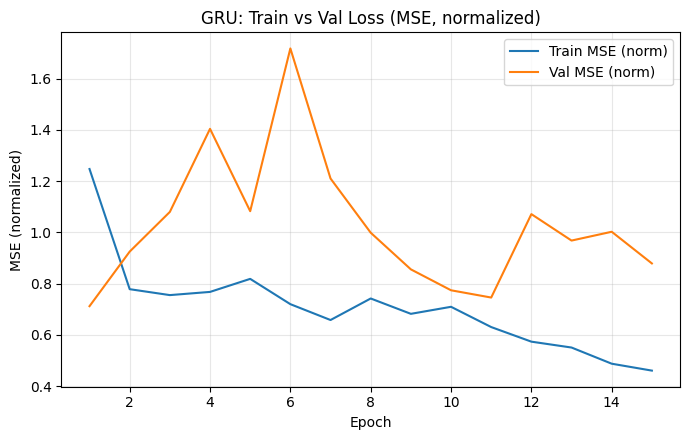

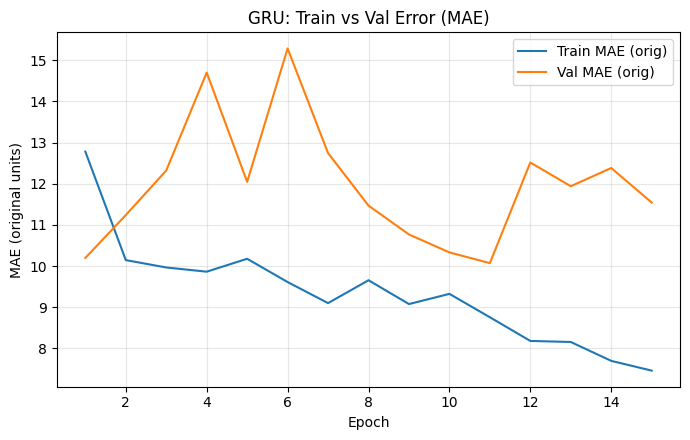

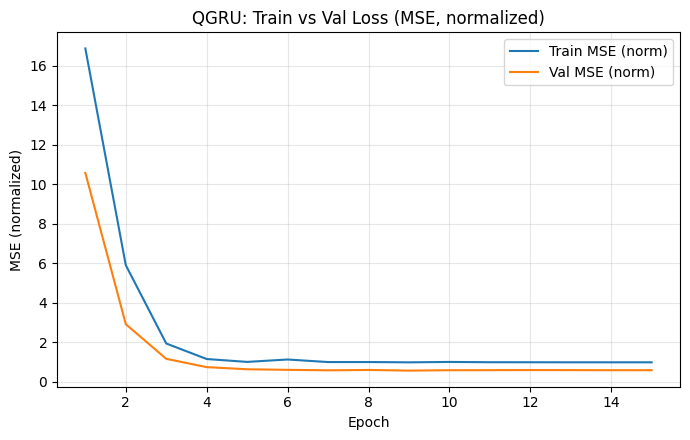

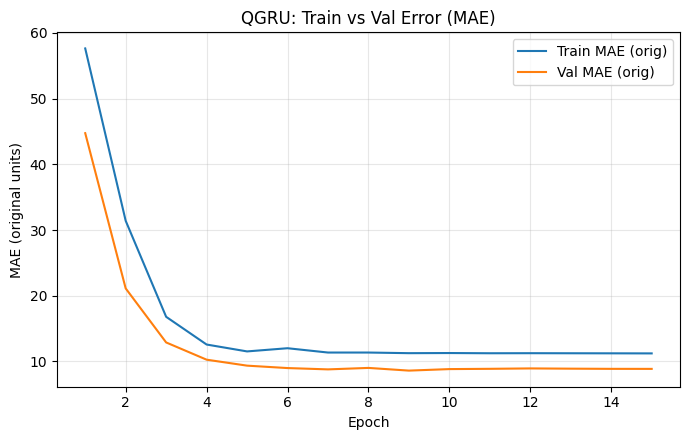

Saved figures to:
  runs/20250829-212046_GRU/gru_loss_mse.png
  runs/20250829-212046_GRU/gru__loss_mae.png
  runs/20250829-211710_QGRU/qgru_loss_mse.png
  runs/20250829-211710_QGRU/qgru__loss_mae.png


In [ ]:
# plot_losses.py
import os
import pandas as pd
import matplotlib.pyplot as plt

GRU_DIR = gru_run_dir
QGRU_DIR = qgru_run_dir


def plot_for_run(run_dir: str, model_name: str):
    csv_path = os.path.join(run_dir, "losses.csv")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Could not find {csv_path}")

    df = pd.read_csv(csv_path)
    # Clean up / enforce expected columns
    expected = ["epoch", "train_mse_norm", "train_mae_orig",
                "val_mse_norm", "val_mae_orig", "lr", "epoch_time_sec"]
    missing = [c for c in expected if c not in df.columns]
    if missing:
        raise ValueError(f"{csv_path} is missing columns: {missing}")

    # Sort by epoch just in case
    df = df.sort_values("epoch")

    # --- Plot MSE (normalized) ---
    plt.figure(figsize=(7, 4.5))
    plt.plot(df["epoch"], df["train_mse_norm"], label="Train MSE (norm)")
    plt.plot(df["epoch"], df["val_mse_norm"],   label="Val MSE (norm)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE (normalized)")
    plt.title(f"{model_name}: Train vs Val Loss (MSE, normalized)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    out_png = os.path.join(run_dir, f"{model_name.lower()}_loss_mse.png")
    plt.savefig(out_png, dpi=150)
    plt.show()

    # --- Plot MAE (original units) ---
    plt.figure(figsize=(7, 4.5))
    plt.plot(df["epoch"], df["train_mae_orig"], label="Train MAE (orig)")
    plt.plot(df["epoch"], df["val_mae_orig"],   label="Val MAE (orig)")
    plt.xlabel("Epoch")
    plt.ylabel("MAE (original units)")
    plt.title(f"{model_name}: Train vs Val Error (MAE)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    out_png = os.path.join(run_dir, f"{model_name.lower()}__loss_mae.png")
    plt.savefig(out_png, dpi=150)
    plt.show()


if __name__ == "__main__":
    plot_for_run(GRU_DIR, "GRU")
    plot_for_run(QGRU_DIR,  "QGRU")
    print("Saved figures to:")
    print(" ", os.path.join(GRU_DIR, "gru_loss_mse.png"))
    print(" ", os.path.join(GRU_DIR, "gru__loss_mae.png"))
    print(" ", os.path.join(QGRU_DIR,  "qgru_loss_mse.png"))
    print(" ", os.path.join(QGRU_DIR,  "qgru__loss_mae.png"))

In [10]:
# import os
# import numpy as np
# import pandas as pd
# import torch
# from torch.utils.data import DataLoader

# # ---- config ----
# csv_path = "first_500k_rows_filtered.csv"
# best_path = GRU_DIR + "/best.pt"  # your best.ckpt path
# examples_to_show = 10
# device = torch.device("cpu")

# # ---------- STRICT feature alignment (no fillers) ----------
# def assert_features_match(df_eval: pd.DataFrame, feat_cols_train):
#     missing = [c for c in feat_cols_train if c not in df_eval.columns]
#     extra   = [c for c in df_eval.columns if c not in feat_cols_train and c not in {"timestamp","tile_id","lat","lon","PM25_ug_m3"}]
#     if missing:
#         raise ValueError(f"CSV is missing {len(missing)} training features (strict, no fillers): {missing[:10]}{'...' if len(missing)>10 else ''}")
#     # reorder to training order; keep only what we need
#     keep = ["timestamp","tile_id","lat","lon","PM25_ug_m3"] + list(feat_cols_train)
#     return df_eval[keep]

# # ---------- rebuild model from checkpoint config ----------
# def build_model_from_ckpt(ckpt, F_in, L_current):
#     cfg   = ckpt["config"]
#     mname = str(cfg.get("model_name", "QGRU")).upper()
#     patch = cfg.get("patcher", {}) or {}
#     P = int(patch.get("patch_len", 16))
#     S = int(patch.get("stride", 8))
#     d_model = int(patch.get("d_model", 128))
#     H_out   = int(cfg.get("head_out", 72))   # model head output length
#     F_exp   = int(patch.get("in_features", F_in))

#     if F_exp != F_in:
#         raise ValueError(f"Feature-count mismatch: checkpoint expects F={F_exp}, but your feat_cols has F={F_in}.")

#     # NOTE: hidden_size/n_qubits/n_qlayers were 128/4/1 in training scripts; keep same defaults here
#     if mname == "QGRU":
#         model = PatchToQGRU72(
#             in_features=F_in, L=L_current, H=H_out,
#             patch_len=P, stride=S, d_model=d_model, hidden_size=128,
#             n_qubits=4, n_qlayers=1, backend="default.qubit"
#         )
#     else:
#         model = PatchToQLSTM72(
#             in_features=F_in, L=L_current, H=H_out,
#             patch_len=P, stride=S, d_model=d_model, hidden_size=128,
#             n_qubits=4, n_qlayers=1, backend="default.qubit"
#         )
#     return model, H_out, P, S

# @torch.no_grad()
# def generalization_smoke_from_csv_strict(csv_path, examples=10):
#     # 1) Load raw and KEEP NATIVE cadence (no resampling/filling)
#     df_raw  = pd.read_csv(csv_path)
#     df_eval = prepare_dataframe_noresample(df_raw, dayfirst=True)

#     # 2) Load checkpoint & pull config (model type, patch params, y stats)
#     ckpt = torch.load(best_path, map_location=device)
#     cfg  = ckpt["config"]
#     y_mean = torch.tensor(cfg["y_mean"], dtype=torch.float32, device=device)
#     y_std  = torch.tensor(cfg["y_std"],  dtype=torch.float32, device=device)

#     # 3) STRICT feature alignment — must match training feat_cols exactly
#     df_eval = assert_features_match(df_eval, feat_cols)  # feat_cols from TRAIN session
#     F = len(feat_cols)

#     # 4) Build the correct model class with the SAME patch params as training
#     #    Use your current L (must be >= P). H will be pulled from the ckpt.
#     model, H_ckpt, P, S = build_model_from_ckpt(ckpt, F_in=F, L_current=L)
#     if P > L:
#         raise ValueError(f"Patch length P={P} from ckpt is longer than L={L}. Set L >= P or retrain.")
#     model = model.to(device)
#     model.load_state_dict(ckpt["model_state"], strict=True)
#     model.eval()

#     # 5) Build eval dataset on native cadence (strict windows, no NaNs)
#     cad_min = dominant_cadence_minutes(df_eval)  # likely 60 from your probes
#     ds_eval = TSWindowDatasetNative(
#         df_eval, L=L, H=H_ckpt, stride=1,
#         stats=(feat_cols, mean, std),  # TRAIN stats (no re-fit!)
#         cadence_min=cad_min
#     )
#     if len(ds_eval) < examples:
#         raise SystemExit(
#             f"[!] Not enough windows in {csv_path} for L={L}, H={H_ckpt}. "
#             f"Found {len(ds_eval)}; need ≥ {examples}. Reduce L/H or use more data."
#         )
#     eval_loader = DataLoader(ds_eval, batch_size=examples, shuffle=True, drop_last=False, collate_fn=collate_keep_meta)

#     # 6) One random batch -> inference (model outputs normalized; convert back)
#     batch   = next(iter(eval_loader))
#     x       = batch["x_hist"].to(device)
#     y_true  = batch["y_future"].to(device)
#     meta    = batch.get("meta", {})
#     y_hat_n = model(x)
#     y_pred  = y_hat_n * y_std + y_mean

#     mae  = torch.mean(torch.abs(y_pred - y_true)).item()
#     rmse = torch.sqrt(torch.mean((y_pred - y_true)**2)).item()
#     B, Hh = y_pred.shape

#     print(f"\n[GENERALIZATION SMOKE – {os.path.basename(csv_path)}] "
#           f"model={cfg.get('model_name')}  P={P} S={S}  L={L} H={H_ckpt}  "
#           f"B={B} | MAE {mae:.2f} µg/m³ | RMSE {rmse:.2f} µg/m³")

#     # 7) Show N examples (all H steps)
#     for i in range(min(examples, B)):
#         try:
#             id_str = f" | tile={meta['tile_id'][i]} start={meta['start_time'][i]}"
#         except Exception:
#             id_str = ""
#         e_mae  = torch.mean(torch.abs(y_pred[i] - y_true[i])).item()
#         e_rmse = torch.sqrt(torch.mean((y_pred[i] - y_true[i])**2)).item()
#         tgt = np.round(y_true[i].cpu().numpy(), 2).tolist()
#         prd = np.round(y_pred[i].cpu().numpy(), 2).tolist()

#         print(f"\nExample {i}{id_str}")
#         print(f" target ({H_ckpt}): {tgt}")
#         print(f"  pred  ({H_ckpt}): {prd}")
#         print(f"  MAE {e_mae:.2f} µg/m³ | RMSE {e_rmse:.2f} µg/m³")

# # --- run it ---
# generalization_smoke_from_csv_strict(csv_path, examples=examples_to_show)

In [ ]:
def pm25_to_aqi(pm25_value: float):
    """
    Convert PM2.5 concentration (µg/m³) to AQI using US EPA breakpoints.
    Returns a tuple (AQI_value, category).
    """
    # Breakpoints: (PM_low, PM_high, AQI_low, AQI_high, Category)
    breakpoints = [
        (0.0, 12.0, 0, 50, "Good"),
        (12.1, 35.4, 51, 100, "Moderate"),
        (35.5, 55.4, 101, 150, "Unhealthy for Sensitive Groups"),
        (55.5, 150.4, 151, 200, "Unhealthy"),
        (150.5, 250.4, 201, 300, "Very Unhealthy"),
        (250.5, 350.4, 301, 400, "Hazardous"),
        (350.5, 500.4, 401, 500, "Hazardous"),
    ]

    for BP_lo, BP_hi, I_lo, I_hi, category in breakpoints:
        if BP_lo <= pm25_value <= BP_hi:
            aqi = (I_hi - I_lo) / (BP_hi - BP_lo) * (pm25_value - BP_lo) + I_lo
            return round(aqi), category

    # Out of range
    return None, "Value out of range (0-500.4 µg/m³)"